In [ ]:
import math

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Predicción de Temperatura Diaria

En esta práctica vamos a trabajar con datos diarios de tempreatura que puedes encontrar [aquí](https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data), en específico se cuenta con 4 series de tiempo: la temperatura promedio, la humedad, la velocidad del viento y la presión promedio. El objetivo es crear un modelo autoregresivo que permita predecir la temperatura promedio del día siguiente.

## 1. Lectura del conjunto de datos

Los datos se organizan en dos archivos `train.csv` y `test.csv` para los conjuntos de entrenamiento y prueba respectivamente. Ambos conjuntos tienen el mismo formato.

In [ ]:
df = pd.read_csv("train.csv", index_col="date")
print(f"len(df): {len(df):,}")
df.head()

len(df): 1,462


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
# Estandarización de los datos
mean = df.mean(axis=0)
std = df.std(axis=0)
df = (df - mean) / std
df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,-2.108778,1.414955,-1.491189,0.025313
2013-01-02,-2.462611,1.862191,-0.837909,0.037149
2013-01-03,-2.494366,1.564034,-0.475464,0.041958
2013-01-04,-2.290231,0.629806,-1.220816,0.033635
2013-01-05,-2.653137,1.554095,-0.680070,0.029936


## 2. Definición del modelo

A diferencia del modelo del cuaderno pasado, aquí no utilizaremos una capa completamente conectada y los logits de la última capa convolucional serán utilizados para la tarea de regresión.

<div style="text-align: center;">
    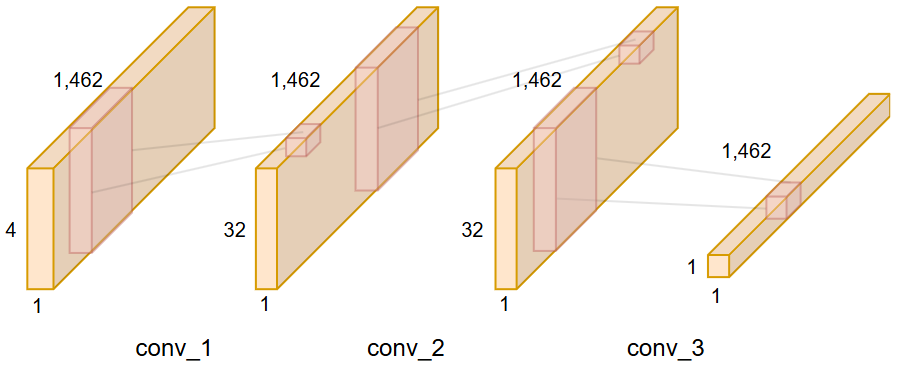
</div>

In [ ]:
class CausalConv1D(torch.nn.Module):
    """
    Capa que aplica una convolución causal 1D utilizando padding. La cantidad
    de padding se define en función del tamaño del kernel, de tal forma que la
    primera operación de convolución tome en cuenta únicamente un valor de la
    secuencia de entrada. Por ejemplo, si la secuencia de entrada es
    [1, 2, 3, 4, 5] y el tamaño del kernel es 3, se agregará un padding de 2,
    transformando la secuencia de entrada a [0, 0, 1, 2, 3, 4, 5]. De esta
    manera, la salida de la convolución y la entrada tendrán la misma longitud.
    """
    def __init__(
        self, in_channels: int, out_channels: int, kernel_size: int
    ) -> None:
        super().__init__()
        self._padding = (kernel_size - 1)
        self._conv1d = torch.nn.Conv1d(in_channels, out_channels, kernel_size)

    def forward(self, x: torch.tensor) -> torch.tensor:
        """
        param x: Tensor de dimensiones [N, C, L]
        :return: Tensor de dimensiones [N, C, L]
        """
        # La tupla representa la cantidad de padding a la izquierda y a la
        # derecha. El padding se realiza en la última dimensión.
        x = torch.nn.functional.pad(x, (self._padding, 0))  # [N, C, L + P]
        return self._conv1d(x)


class CausalConvNet(torch.nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        kernel_size: int
    ) -> None:
        super().__init__()
        self._conv1 = torch.nn.Sequential(
            CausalConv1D(
                in_channels=4,
                out_channels=hidden_size,
                kernel_size=kernel_size
            ),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.ReLU(),
        )
        self._conv2 = torch.nn.Sequential(
            CausalConv1D(
                in_channels=hidden_size,
                out_channels=hidden_size,
                kernel_size=kernel_size
            ),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.ReLU(),
        )
        self._conv3 = CausalConv1D(
            in_channels=hidden_size,
            out_channels=output_size,
            kernel_size=kernel_size
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        """
        :param x: Tensor de dimensiones [1, 4, 1_462]
        :return: Tensor de dimensiones [1, 1, 1462]
        """
        x = self._conv1(x)  # [1, hidden_size, 1462]
        x = self._conv2(x)  # [1, hidden_size, 1462]
        x = self._conv3(x)  # [1, output_size, 1462]
        return x


## 3. Entrenamiento del modelo

In [ ]:
# Definición de las entradas y etiquetas del modelo

## Entradas al modelo
features = df[["meantemp", "humidity", "wind_speed", "meanpressure"]]
features = torch.tensor(features.to_numpy(), dtype=torch.float32)  # [L, C]
# Agregamos una dimensión debido a que es lo que espera BatchNorm1D
features = features.T.unsqueeze(0)  # [1, C, L]

## Etiquetas del modelo
labels = df[["meantemp"]]
labels = torch.tensor(labels.to_numpy(), dtype=torch.float32) # [L, C]
# La función de MSE espera que las etiquetas tengan las mismas dimensiones que
# las entradas.
labels = labels.T.unsqueeze(0)  # [1, C, L]

# Definición de modelo, pérdida y optimizador
model = CausalConvNet(
    input_size=4, hidden_size=32, output_size=1, kernel_size=5
).train()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Ciclo de entrenamiento
epochs = 100
loss_history = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(features)
    # Como queremos un modelo autoregresivo, utilizamos los primeros L - 1
    # elementos de la secuencia para predecir los últimos L - 1 elementos.
    loss = criterion(output[:, :, :-1], labels[:, :, 1:])
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    print(
        f"Epoch {epoch + 1}/{epochs}, MSE: {loss.item()}, "
        f"RMSE: {math.sqrt(loss.item())}"
    )

Epoch 1/100, MSE: 1.1604936122894287, RMSE: 1.0772620908067956
Epoch 2/100, MSE: 0.8846814036369324, RMSE: 0.9405750388123918
Epoch 3/100, MSE: 0.6643406748771667, RMSE: 0.8150709630928873
Epoch 4/100, MSE: 0.4981524348258972, RMSE: 0.7057991462348883
Epoch 5/100, MSE: 0.3774302005767822, RMSE: 0.6143534817812806
Epoch 6/100, MSE: 0.2922245264053345, RMSE: 0.5405779559002887
Epoch 7/100, MSE: 0.23379410803318024, RMSE: 0.4835226034356411
Epoch 8/100, MSE: 0.19608764350414276, RMSE: 0.44281784460898
Epoch 9/100, MSE: 0.1734980195760727, RMSE: 0.4165309347168259
Epoch 10/100, MSE: 0.16187842190265656, RMSE: 0.40234117599700947
Epoch 11/100, MSE: 0.15767689049243927, RMSE: 0.3970854951927094
Epoch 12/100, MSE: 0.15770180523395538, RMSE: 0.39711686596511536
Epoch 13/100, MSE: 0.15956655144691467, RMSE: 0.399457821862227
Epoch 14/100, MSE: 0.1614445596933365, RMSE: 0.4018016422232947
Epoch 15/100, MSE: 0.16225165128707886, RMSE: 0.40280473096412217
Epoch 16/100, MSE: 0.1612357646226883, RMS

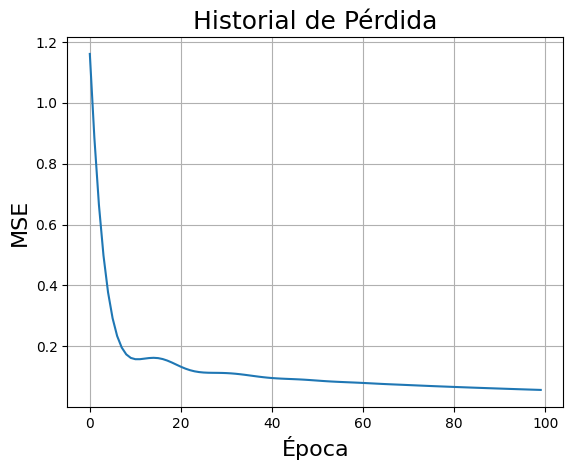

In [ ]:
# Gráfica de la función de pérdida
plt.title("Historial de Pérdida", fontsize=18)
plt.xlabel("Época", fontsize=16)
plt.ylabel("MSE", fontsize=16)
plt.plot(loss_history)
plt.grid()
plt.show()

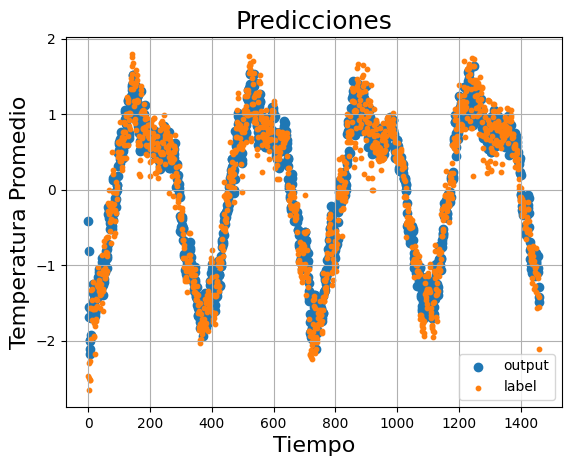

In [ ]:
# Gráfica comparando las predicciones con los valores reales
model.eval()
with torch.no_grad():
    output = model(features)

plt.scatter(range(len(output.ravel()[:-1])), output.ravel()[:-1], label="output")
plt.scatter(range(len(labels.ravel()[1:])), labels.ravel()[1:], label="label", s=10)
plt.xlabel("Tiempo", fontsize=16)
plt.ylabel("Temperatura Promedio", fontsize=16)
plt.title("Predicciones", fontsize=18)
plt.legend(loc="best")
plt.plot()
plt.grid()
plt.show()

## 4. Evaluación del modelo

In [ ]:
df_test = pd.read_csv("test.csv", index_col="date")
# Estandarizamos los datos con las estadísticas calculadas en el conjunto de
# entrenamiento.
df_test = (df_test - mean) / std
print(f"len(df_test): {len(df_test):,}")

len(df_test): 114


In [ ]:
# Test dataset
test_features = df_test[["meantemp", "humidity", "wind_speed", "meanpressure"]]
test_features = torch.tensor(test_features.to_numpy(), dtype=torch.float32)
test_features = test_features.T.unsqueeze(0)

test_labels = df_test[["meantemp"]]
test_labels = torch.tensor(test_labels.to_numpy(), dtype=torch.float32)
test_labels = test_labels.T.unsqueeze(0)

model.eval()
with torch.no_grad():
    output = model(test_features)
    loss = criterion(output, test_labels)
print(f"MSE: {loss.item()}")
print(f"RMSE: {math.sqrt(loss.item())}")

MSE: 0.09789121896028519
RMSE: 0.31287572446625705


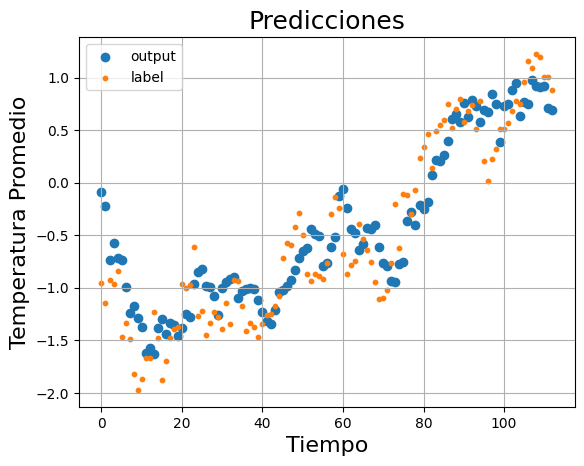

In [ ]:
plt.scatter(range(len(output.ravel()[:-1])), output.ravel()[:-1], label="output")
plt.scatter(range(len(test_labels.ravel()[1:])), test_labels.ravel()[1:], label="label", s=10)

plt.xlabel("Tiempo", fontsize=16)
plt.ylabel("Temperatura Promedio", fontsize=16)
plt.title("Predicciones", fontsize=18)
plt.legend(loc="best")
plt.plot()
plt.grid()
plt.show()